In [1]:
from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/PTI'

Mounted at /content/drive


---
#**0. PREPARATION**

### 0.1 IMPORTANT: Check kernel and environment prior to run
The conda environment for these scripts is available on GitHub at https://github.com/wbPTI/sahelPTIdata/tree/main/vignettes/pti_env.yml.
<br><br>Once you've activated the PTI environment and loaded this Jupyter Notebook script, make sure it is using the "pti" kernel (see top right, under Logout button). If it is not, you must navigate to the top ribbon and go to: **Kernel -> Change Kernel -> pti** prior to running.

### 0.2 Expected inputs

This script uses ACLED conflict events, admin areas, and population.

##### ADMIN AREAS: Source file type: geopackage.
See Auxilliary_Prep for notes.

##### ACLED: Source file type: shapefile.
This script is designed to use the original ACLED dataset, converted to shapefile format. User must change source file name in script if not using the Africa 1997-2023 file. Also note that the [[]] drop line in 2.1 will fail if those columns are not present.

##### POPULATION: Source file type: .tif.
This takes the WGS84 population raster made in Auxilliary_Prep.

### 0.3 Outputs

This script produces indicators per admin area related to population exposure to conflict and conflict-related fatalities (Conflict_PopExposed_Rate_ADM.csv).

### 0.4 Pseudocode (outline of the following script)

##### Narrow down conflict events
Subset conflict events by year (2017-2022 and Oct22-Mar23) and event type (exclude protest, strat dev).
<br> Clip conflict events by Sahel countries with 20km buffer.

##### Simple summary indicators
Spatial join ADM3 (with ADM2 and 1 codes) onto conflict events.
<br> Group-by ADM: count features (Conflict_6y_ADMX) and sum fatalities

##### Find populations in conflict zones
Remove geoprecision==3 events.
<br> Buffer conflict events by 20km and dissolve.
<br> Clip admin areas by the buffered conflict zone.
<br> Zonal statistics: WorldPop in conflict 20km zone.

##### Aggregate to ADM
Group-by ADM: sum population (field= ConfPop_6y). Save to file (number of people exposed to 1 or more violent conflicts)

##### Calculate per 1k people exposed
ConfPerCap_6y = Conflict_6y / ConfPop_6y * 1000
<br> Save to file.

---
# **1. PREPARE WORKSPACE**

In [22]:
!pip install geopandas rioxarray richdem geemap rasterio import_ipynb pyshp pycrs pyogrio rasterstats xarray-spatial

In [23]:
# Built-in:
# dir(), print(), range(), format(), int(), len(), list(), max(), min(), zip(), sorted(), sum(), open(), del, = None, try except, with as, for in, if elif else
# Also: list.append(), list.insert(), list.remove(), count(), startswith(), endswith(), contains(), replace()

import os, sys, glob, re, time, subprocess, string # os.getcwd(), os.path.join(), os.listdir(), os.remove(), time.ctime(), glob.glob(), string.zfill(), string.join()
from os.path import exists # exists()
from functools import reduce # reduce()

import geopandas as gpd # read_file(), GeoDataFrame(), sjoin_nearest(), to_crs(), to_file(), .crs, buffer(), dissolve()
import pandas as pd # .dtypes, Series(), concat(), DataFrame(), read_table(), merge(), to_csv(), .loc[], head(), sample(), astype(), unique(), rename(), between(), drop(), fillna(), idxmax(), isna(), isin(), apply(), info(), sort_values(), notna(), groupby(), value_counts(), duplicated(), drop_duplicates()

from shapely.geometry import Point, LineString, Polygon, shape, MultiPoint
from shapely.ops import cascaded_union
from shapely.validation import make_valid  # in apply(make_valid)
import shapely.wkt
import matplotlib.pyplot as plt

import numpy as np # median(), mean(), tolist(), .inf
import fiona, rioxarray # fiona.open()
import rasterio # open(), write_band(), .name, .count, .width, .height. nodatavals, .meta, update(), copy(), write()

import xrspatial
import rioxarray


from rasterio.plot import show
from rasterio import features # features.rasterize()
from rasterio.features import shapes
from rasterio import mask # rasterio.mask.mask()
from rasterio.enums import Resampling # rasterio.enums.Resampling()
from rasterstats import zonal_stats
from osgeo import gdal, osr, ogr, gdal_array, gdalconst # Open(), SpatialReference, WarpOptions(), Warp(), GetDataTypeName(), GetRasterBand(), GetNoDataValue(), Translate(), GetProjection(), GetAttrValue()


import import_ipynb
import importlib


# Import external files
os.chdir(program_location)
!pwd
import config

sys.path.append(program_location)

import tools
importlib.reload(tools)

/content/drive/MyDrive/Colab Notebooks/PTI


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/PTI/tools.py'>

In [24]:
data_loc = os.path.join(os.getcwd(), 'data', config.ISO)
print(data_loc)


# The usual directories
Current_Fd = os.path.join(data_loc, 'Conflict')
Source_Fd = os.path.join(program_location, 'data', 'common')

# Auxilliary sources
ADM_Fd = os.path.join(data_loc, 'ADM')
src_ADM3 = os.path.join(ADM_Fd, 'Source', config.original_adm3_fil)
WP_Fd = os.path.join(data_loc, 'WorldPop')

# Check paths
print('\n\n'.join([data_loc, Current_Fd, Source_Fd, ADM_Fd, WP_Fd]))

/content/drive/MyDrive/Colab Notebooks/PTI/data/CPV
/content/drive/MyDrive/Colab Notebooks/PTI/data/CPV

/content/drive/MyDrive/Colab Notebooks/PTI/data/CPV/Conflict

/content/drive/MyDrive/Colab Notebooks/PTI/data/common

/content/drive/MyDrive/Colab Notebooks/PTI/data/CPV/ADM

/content/drive/MyDrive/Colab Notebooks/PTI/data/CPV/WorldPop


---
#**2. NARROW DOWN CONFLICT EVENTS**

### 2.1 By event type

In [25]:
ACLED = tools.vec_import(config.RW_engine, os.path.join(Source_Fd, 'ACLED_1997_202304_AFR.shp'))
ACLED.to_crs('ESRI:102022', inplace = True)

ACLED.info()
ACLED.crs

Vector import complete.
GDF size:317433
EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 317433 entries, 0 to 317432
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   event_id_c  317433 non-null  object  
 1   event_date  317433 non-null  object  
 2   year        317433 non-null  int64   
 3   time_preci  317433 non-null  int64   
 4   disorder_t  317433 non-null  object  
 5   event_type  317433 non-null  object  
 6   sub_event_  317433 non-null  object  
 7   actor1      317433 non-null  object  
 8   assoc_acto  84538 non-null   object  
 9   inter1      317433 non-null  int64   
 10  actor2      230807 non-null  object  
 11  assoc_ac_1  62598 non-null   object  
 12  inter2      317433 non-null  int64   
 13  interactio  317433 non-null  int64   
 14  civilian_t  96027 non-null   object  
 15  iso         317433 non-null  int64   
 16  region      317433 non-null  object  
 17  country  

<Projected CRS: ESRI:102022>
Name: Africa_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Africa
- bounds: (-25.0, -35.0, 55.0, 39.0)
Coordinate Operation:
- name: Africa_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# Drop what we're not using
ACLED = ACLED[['event_date', 'year', 'event_type', 'geo_precis', 'fatalities', 'geometry']]

In [27]:
ACLED.event_type.unique()

array(['Protests', 'Riots', 'Strategic developments',
       'Explosions/Remote violence', 'Battles',
       'Violence against civilians'], dtype=object)

In [28]:
ACLED = ACLED.loc[(ACLED['event_type'] != 'Strategic developments') & (ACLED['event_type'] != 'Protests')]
ACLED.event_type.unique()

array(['Riots', 'Explosions/Remote violence', 'Battles',
       'Violence against civilians'], dtype=object)

Make sure fatalities are all numeric before splitting data into subsets.

In [29]:
ACLED.fatalities = pd.to_numeric(ACLED.fatalities, errors='coerce').fillna(0)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 2.2 By year

##### From 2017 to 2022 (6 year timeframe)

In [30]:
ACLED[['event_date', 'year']].sample(10)

,event_date,year
224971,29 April 2014,2014
312657,29 April 1998,1998
81503,15 January 2021,2021
191523,18 April 2016,2016
69153,23 May 2021,2021
194834,13 February 2016,2016
112706,12 February 2020,2020
118357,03 December 2019,2019
32717,25 May 2022,2022
80476,25 January 2021,2021


In [31]:
ACLED_6y = ACLED.loc[(ACLED['year'] > 2016) & (ACLED['year'] < 2023)]
ACLED_6y.year.unique()

array([2022, 2021, 2020, 2019, 2018, 2017])

##### From October 2022 to March 2023 (6 month timeframe)

In [32]:
Last6Months = ['October', 'November', 'December', 'January', 'February', 'March']
ACLED['Last6'] = np.where(ACLED['event_date'].str.contains('|'.join(Last6Months)), ACLED['event_date'], 'NoData')

In [33]:
ACLED_6mo = ACLED.loc[(ACLED['Last6'] != 'NoData') & (ACLED['year'] > 2021)].drop(columns=['Last6'])
ACLED_6mo[['event_date']].sample(20)

,event_date
9076,16 January 2023
12633,10 December 2022
41749,22 February 2022
4103,05 March 2023
38398,26 March 2022
41271,26 February 2022
8805,18 January 2023
19282,09 October 2022
17023,29 October 2022
38509,25 March 2022


### 2.2 Clip to area of interest

Vector import complete.
GDF size:32
EPSG:4326


<Axes: >

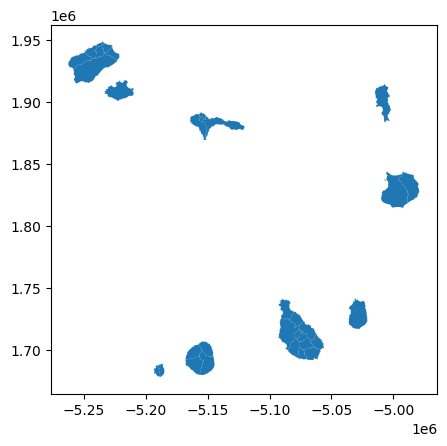

In [34]:
# Read the original ADM3 layer for the target country
ADM3 = tools.vec_import(config.RW_engine, src_ADM3)
ADM3.to_crs('ESRI:102022', inplace = True)

# Rename the admin code cols
ADM3 = ADM3.rename(columns = config.l_replace)

# Check
ADM3.plot()

ESRI:102022


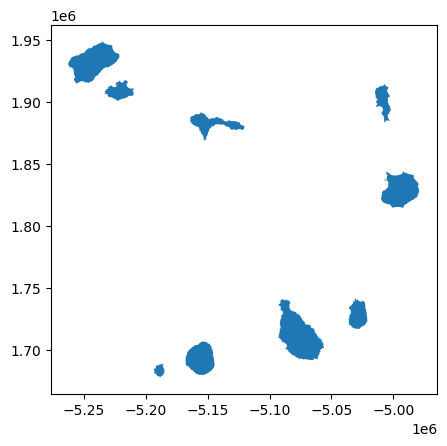

In [35]:
ADM0 = ADM3.dissolve('ADM0_CODE')

# Check
ADM0.plot()
print(ADM0.crs)

##### Create buffered area of interest so that conflict events across the border are still eligible.

In [36]:
ADM0['geometry'] = ADM0['geometry'].apply(make_valid).buffer(20000) # make_valid is a workaround for any null geometries.

<Axes: >

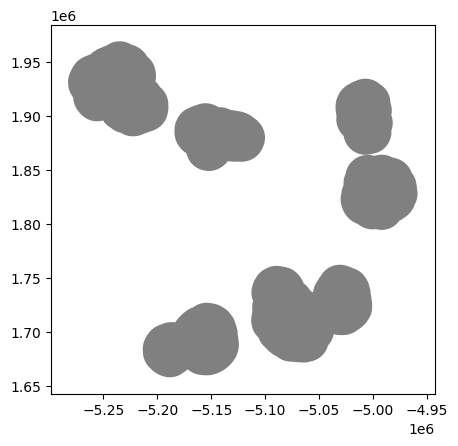

In [37]:
fig, ax = plt.subplots()
ADM0.plot(ax=ax, color='gray')

In [38]:
ACLED_6y = gpd.clip(ACLED_6y, mask=ADM0)
ACLED_6mo = gpd.clip(ACLED_6mo, mask=ADM0)
print(ACLED_6y.info(), ACLED_6mo.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10 entries, 45360 to 12509
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   event_date  10 non-null     object  
 1   year        10 non-null     int64   
 2   event_type  10 non-null     object  
 3   geo_precis  10 non-null     int64   
 4   fatalities  10 non-null     int64   
 5   geometry    10 non-null     geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 560.0+ bytes
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3 entries, 45360 to 12509
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   event_date  3 non-null      object  
 1   year        3 non-null      int64   
 2   event_type  3 non-null      object  
 3   geo_precis  3 non-null      int64   
 4   fatalities  3 non-null      int64   
 5   geometry    3 non-null      geometry
dtypes: geometry(1), int64(

---
#**3. SIMPLE SUMMARY INDICATORS**

### 3.1 Spatial join ADM onto conflict events.

In [39]:
ADM3 = ADM3[['ADM3_CODE', 'ADM2_CODE', 'ADM1_CODE', 'geometry']]

In [40]:
ACLED_6y = gpd.sjoin(ACLED_6y, ADM3, how='left', predicate='within')
ACLED_6y.sample(5) # Some ADM values will be NaN because conflicts outside of the Sahel are included.

,event_date,year,event_type,geo_precis,fatalities,geometry,index_right,ADM3_CODE,ADM2_CODE,ADM1_CODE
76893,03 March 2021,2021,Violence against civilians,1,0,POINT (-5064566.290 1694986.749),23,CPV0060120023,CPV006012,CPV006
108746,29 March 2020,2020,Violence against civilians,1,0,POINT (-5069746.800 1717767.937),29,CPV0060110029,CPV006011,CPV006
12509,11 December 2022,2022,Riots,1,0,POINT (-5222513.800 1913905.318),13,CPV0010030013,CPV001003,CPV001
90433,16 October 2020,2020,Riots,1,0,POINT (-5069746.800 1717767.937),29,CPV0060110029,CPV006011,CPV006
89039,29 October 2020,2020,Violence against civilians,1,0,POINT (-5222513.800 1913905.318),13,CPV0010030013,CPV001003,CPV001


In [41]:
ACLED_6mo = gpd.sjoin(ACLED_6mo, ADM3, how='left', predicate='within')
ACLED_6mo.sample(2) # Some ADM values will be NaN because conflicts outside of the Sahel are included.

,event_date,year,event_type,geo_precis,fatalities,geometry,index_right,ADM3_CODE,ADM2_CODE,ADM1_CODE
12509,11 December 2022,2022,Riots,1,0,POINT (-5222513.800 1913905.318),13,CPV0010030013,CPV001003,CPV001
45360,21 January 2022,2022,Riots,1,0,POINT (-5167088.626 1688810.774),16,CPV0070190016,CPV007019,CPV007


In [42]:
print('No. of unique AMD3 in the ACLED_6y df = {}'.format(ACLED_6y['ADM3_CODE'].nunique()))
print('No. of unique AMD3 in the ACLED_6mo df = {}'.format(ACLED_6mo['ADM3_CODE'].nunique()))

No. of unique AMD3 in the ACLED_6y df = 5
No. of unique AMD3 in the ACLED_6mo df = 3


### 3.2 Aggregate to ADM with group-by

In [43]:
TimeFrames = {'6y':ACLED_6y, '6mo':ACLED_6mo}
AllSummaries = pd.DataFrame(ADM3)[['ADM3_CODE', 'ADM2_CODE', 'ADM1_CODE']]

In [44]:
for key in TimeFrames:
    for ADM in ['ADM1', 'ADM2', 'ADM3']:
        ADM_ID = ''.join([ADM, '_CODE'])

        GroupedVals = pd.DataFrame(TimeFrames[key])[['fatalities', ADM_ID]].groupby(ADM_ID, as_index=False).sum()
        GroupedVals = GroupedVals.rename(columns={'fatalities':'_'.join(['Fatal', key, ADM])})

        AllSummaries = AllSummaries.merge(GroupedVals, how = 'left', on=ADM_ID)

        GroupedVals = pd.DataFrame(TimeFrames[key])[['fatalities', ADM_ID]].groupby(ADM_ID, as_index=False).count()
        GroupedVals = GroupedVals.rename(columns={'fatalities':'_'.join(['Conflict', key, ADM])})

        AllSummaries = AllSummaries.merge(GroupedVals, how = 'left', on=ADM_ID)


AllSummaries.fillna(0, inplace = True)
print(AllSummaries.sample(20))

# While we'd expect most 6-month results to be significantly less than the 6-year results in the same ADM and row,
# it's possible for some 6-month period results to be more than the corresponding 6-year value, since it extends past 2022.
# But all conflict results should be less than or equal to their corresponding fatalities.

        ADM3_CODE  ADM2_CODE ADM1_CODE  Fatal_6y_ADM1  Conflict_6y_ADM1  \
3   CPV0000000003  CPV000000    CPV000            0.0               0.0   
7   CPV0030060007  CPV003006    CPV003            0.0               0.0   
22  CPV0060130022  CPV006013    CPV006            0.0               7.0   
17  CPV0070190017  CPV007019    CPV007            0.0               1.0   
20  CPV0080210020  CPV008021    CPV008            0.0               0.0   
12  CPV0020040012  CPV002004    CPV002            0.0               0.0   
18  CPV0070180018  CPV007018    CPV007            0.0               1.0   
1   CPV0000020001  CPV000002    CPV000            0.0               0.0   
14  CPV0050080014  CPV005008    CPV005            0.0               0.0   
13  CPV0010030013  CPV001003    CPV001            0.0               2.0   
15  CPV0070200015  CPV007020    CPV007            0.0               1.0   
25  CPV0060140025  CPV006014    CPV006            0.0               7.0   
5   CPV0000000005  CPV000

In [45]:
# Export 'Sum_ConflictAndFatalities_ADM.csv' to the 'Intermediate' folder.

OUT_fil = os.path.join(data_loc, 'Conflict','Intermediate')

if not os.path.exists(OUT_fil):
    os.mkdir(OUT_fil)


AllSummaries.to_csv(os.path.join(OUT_fil, 'Sum_ConflictAndFatalities_ADM.csv'))

---
#**4. FIND POPULATIONS IN CONFLICT ZONES**

### 4.1 Remove imprecise conflict locations

In [46]:
ACLED_6y = ACLED_6y[ACLED_6y['geo_precis'] != 3]
ACLED_6mo = ACLED_6mo[ACLED_6mo['geo_precis'] != 3]

### 4.2 Buffer (10km) and dissolve conflict sites

In [47]:
ACLED_6y['geometry'] = ACLED_6y['geometry'].apply(make_valid).buffer(10000)
ACLED_6mo['geometry'] = ACLED_6mo['geometry'].apply(make_valid).buffer(10000)

In [48]:
ACLED_6y = ACLED_6y.dissolve()
ACLED_6mo = ACLED_6mo.dissolve()

### 4.3 Clip ADM3 to conflict mask

In [49]:
ADM3['geometry'], ACLED_6y['geometry'], ACLED_6mo['geometry'] = ADM3['geometry'].apply(make_valid), ACLED_6y['geometry'].apply(make_valid), ACLED_6mo['geometry'].apply(make_valid)

ADM3_6y = gpd.clip(ADM3, mask=ACLED_6y)
ADM3_6mo = gpd.clip(ADM3, mask=ACLED_6mo)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Vector export complete.
ESRI:102022


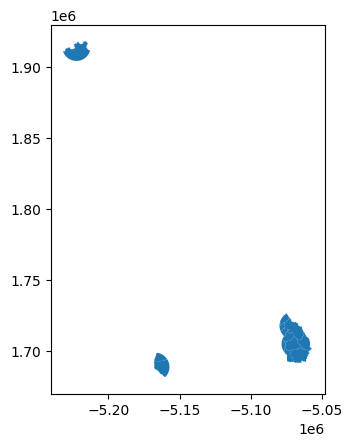

In [50]:
ADM3_6y.plot()
tools.vec_export(config.RW_engine, ADM3_6y, os.path.join(Current_Fd, 'Intermediate', 'ADM3_6y_buf.shp'))
print(ADM3_6y.crs)

Vector export complete.
ESRI:102022


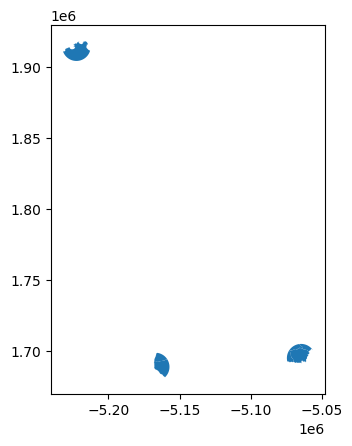

In [51]:
ADM3_6mo.plot()
tools.vec_export(config.RW_engine, ADM3_6mo, os.path.join(Current_Fd, 'Intermediate', 'ADM3_6mo_buf.shp'))
print(ADM3_6mo.crs)

### 4.4 Zonal statistics

Reproject the WorldPop to the same CRS (should be a Projected Coordinate System: PCS) as the conflict buffers (i.e., ADM3_6y and ADM3_6mo).

In [52]:
# Reproject the WorldPop raster using rioxarray.

PCS = 'ESRI:102022'

RX_raster = rioxarray.open_rasterio(os.path.join(WP_Fd, 'Source', config.original_WP_fil))
RX_raster = RX_raster.rio.reproject(PCS)

In [53]:
# Check CRS of 3 input layers (i.e., ADM3_6y, ADM3_6mo, and WorldPop)

if ADM3_6y.crs == ADM3_6mo.crs and ADM3_6y.crs == RX_raster.rio.crs and ADM3_6mo.crs == RX_raster.rio.crs:
  print('OK')
  print('ADM3_6y : CRS = {}'.format(ADM3_6y.crs))
  print('ADM3_6mo : CRS = {}'.format(ADM3_6mo.crs))
  print('WorldPop : CRS = {}'.format(RX_raster.rio.crs))

else:
  print('The CRS of the 3 input layers must be same Projected Coordinate System')
  print('ADM3_6y : CRS = {}'.format(ADM3_6y.crs))
  print('ADM3_6mo : CRS = {}'.format(ADM3_6mo.crs))
  print('WorldPop : CRS = {}'.format(RX_raster.rio.crs))

OK
ADM3_6y : CRS = ESRI:102022
ADM3_6mo : CRS = ESRI:102022
WorldPop : CRS = ESRI:102022


In [54]:
#Change the WorldPop NO DATA (-99999) value to 0 to avoid miscomputation.

RX_raster.rio.write_nodata(0, inplace=True)
RX_raster.rio.nodata

np.place(RX_raster[0, :, :].values, RX_raster[0, :, :].values == -99999, 0)

In [55]:
ADM3_6y.sort_values('ADM3_CODE', inplace = True)
ADM3_6mo.sort_values('ADM3_CODE', inplace = True)

Apply 'reset_index'
NOTE: pd.concat in the later block will concat(merge) 2 DFs via FID (i.e., DF index).
So, it is crucial to ensure the index order of the 2 DFs must be the same. To ensure this, here, the index of ADM3_6y and ADM3_6mo is first reset.

In [56]:
# Zonal stats for 6 year layer
stats_6y = zonal_stats(ADM3_6y,
                    RX_raster[0,:,:].values,
                    affine = RX_raster.rio.transform(),
                    stats = ["sum"])

/usr/local/lib/python3.10/dist-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [57]:
df_stats_6y = pd.DataFrame(stats_6y)
gdf_ADM3_6y_copy = ADM3_6y.copy()

gdf_ADM3_6y_copy.reset_index(inplace = True, drop = True)
Pop6y_ADM = pd.concat([gdf_ADM3_6y_copy, df_stats_6y], axis = 1)

Pop6y_ADM.drop(columns='geometry', inplace = True)
Pop6y_ADM.rename(columns={'sum': 'ConfPop_6y_ADM3'}, inplace = True)


# Export a CSV for double-check
Pop6y_ADM.to_csv(os.path.join(OUT_fil, 'Pop6y_ADM_check.csv'))

In [58]:
# Zonal stats for 6 month layer
stats_6mo = zonal_stats(ADM3_6mo,
                    RX_raster[0,:,:].values,
                    affine = RX_raster.rio.transform(),
                    stats = ["sum"])

In [59]:
df_stats_6mo = pd.DataFrame(stats_6mo)
gdf_ADM3_6mo_copy = ADM3_6mo.copy()

gdf_ADM3_6mo_copy.reset_index(inplace = True, drop = True)
Pop6mo_ADM = pd.concat([gdf_ADM3_6mo_copy, df_stats_6mo], axis = 1)

Pop6mo_ADM.drop(columns='geometry', inplace = True)
Pop6mo_ADM.rename(columns={'sum': 'ConfPop_6mo_ADM3'}, inplace = True)


# Export a CSV for double-check
Pop6mo_ADM.to_csv(os.path.join(OUT_fil, 'Pop6mo_ADM_check.csv'))

---
#**5. AGGREGATE TO OTHER ADMS**

In [60]:
# First, get all admin3 codes from the original adm GDF as a deep copy to df_temp (DO NOT use a shallow copy to avoid computational errors)
df_temp = ADM3[['ADM1_CODE', 'ADM2_CODE', 'ADM3_CODE']].copy()

In [61]:
# Process 6 years

#First, the values at the adm3 level (i.e., the Pop6y_ADM df) should be merged to the df_temp:
df_merge_temp = Pop6y_ADM[['ADM3_CODE', 'ConfPop_6y_ADM3']].copy()
df_temp = df_temp.merge(df_merge_temp, how='left', on='ADM3_CODE')


# Groping to adm2 level
df_merge_temp = Pop6y_ADM[['ConfPop_6y_ADM3', 'ADM2_CODE']].groupby('ADM2_CODE', as_index=False).sum()
df_merge_temp.rename(columns={'ConfPop_6y_ADM3':'ConfPop_6y_ADM2'}, inplace = True)
df_temp = df_temp.merge(df_merge_temp, how='left', on='ADM2_CODE')


# Groping to adm1 level
df_merge_temp = Pop6y_ADM[['ConfPop_6y_ADM3', 'ADM1_CODE']].groupby('ADM1_CODE', as_index=False).sum()
df_merge_temp.rename(columns={'ConfPop_6y_ADM3':'ConfPop_6y_ADM1'}, inplace = True)
df_temp = df_temp.merge(df_merge_temp, how='left', on='ADM1_CODE')


# Check the result
df_temp.sample(5)

,ADM1_CODE,ADM2_CODE,ADM3_CODE,ConfPop_6y_ADM3,ConfPop_6y_ADM2,ConfPop_6y_ADM1
16,CPV007,CPV007019,CPV0070190016,3492.865723,5991.468750,5991.468750
23,CPV006,CPV006012,CPV0060120023,16844.492188,16844.492188,207658.512817
11,CPV002,CPV002004,CPV0020040011,NaN,NaN,NaN
25,CPV006,CPV006014,CPV0060140025,3290.594727,3290.594727,207658.512817
24,CPV006,CPV006009,CPV0060090024,NaN,NaN,207658.512817


In [62]:
# Process 6 months

#First, the values at the adm3 level (i.e., the Pop6mo_ADM df) should be merged to the df_temp:
df_merge_temp = Pop6mo_ADM[['ADM3_CODE', 'ConfPop_6mo_ADM3']].copy()
df_temp = df_temp.merge(df_merge_temp, how='left', on='ADM3_CODE')


# Groping to adm2 level
df_merge_temp = Pop6mo_ADM[['ConfPop_6mo_ADM3', 'ADM2_CODE']].groupby('ADM2_CODE', as_index=False).sum()
df_merge_temp.rename(columns={'ConfPop_6mo_ADM3':'ConfPop_6mo_ADM2'}, inplace = True)
df_temp = df_temp.merge(df_merge_temp, how='left', on='ADM2_CODE')


# Groping to adm1 level
df_merge_temp = Pop6mo_ADM[['ConfPop_6mo_ADM3', 'ADM1_CODE']].groupby('ADM1_CODE', as_index=False).sum()
df_merge_temp.rename(columns={'ConfPop_6mo_ADM3':'ConfPop_6mo_ADM1'}, inplace = True)
df_temp = df_temp.merge(df_merge_temp, how='left', on='ADM1_CODE')


# Check the result
df_temp.sample(5)

,ADM1_CODE,ADM2_CODE,ADM3_CODE,ConfPop_6y_ADM3,ConfPop_6y_ADM2,ConfPop_6y_ADM1,ConfPop_6mo_ADM3,ConfPop_6mo_ADM2,ConfPop_6mo_ADM1
5,CPV000,CPV000000,CPV0000000005,NaN,NaN,NaN,NaN,NaN,NaN
11,CPV002,CPV002004,CPV0020040011,NaN,NaN,NaN,NaN,NaN,NaN
14,CPV005,CPV005008,CPV0050080014,NaN,NaN,NaN,NaN,NaN,NaN
24,CPV006,CPV006009,CPV0060090024,NaN,NaN,207658.512817,NaN,NaN,24069.040039
9,CPV004,CPV004007,CPV0040070009,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# The length of df_temp must be equal to the lenght of the ADM3 df:

if len(df_temp) != len(ADM3):
  print('Error!')

else:
  print('Merge process is complete without errors')

Merge process is complete without errors


In [64]:
# Check the data type in df_temp.
df_temp.dtypes

ADM1_CODE            object
ADM2_CODE            object
ADM3_CODE            object
ConfPop_6y_ADM3     float64
ConfPop_6y_ADM2     float64
ConfPop_6y_ADM1     float64
ConfPop_6mo_ADM3    float64
ConfPop_6mo_ADM2    float64
ConfPop_6mo_ADM1    float64
dtype: object

In [65]:
# We can just simply apply the 'fillna' method here as the df_temp only contains str cols (for admins) and float64 for the computed pop values.
df_temp.fillna(0, inplace = True)

# For merging to the AllSummarles df, we dln't need ADM1 and ADM2 cols, hence;
df_temp.drop(['ADM1_CODE', 'ADM2_CODE'], axis=1, inplace = True)

# Merge and export:
AllSummaries = AllSummaries.merge(df_temp, how='left', on = 'ADM3_CODE')

In [66]:
# Export
AllSummaries.to_csv(os.path.join(Current_Fd, 'Intermediate', 'Conflict_PopExposed_ADM.csv'))

---
#**6. CALCULATE PER 1K PEOPLE EXPOSED**

In [67]:
for Indicator in ['Conflict', 'Fatal']:
    for TimeFrame in ['6y', '6mo']:
        for ADM in ['ADM3', 'ADM2', 'ADM1']:

            ADM_field = ADM + '_CODE'

            IndicField = '_'.join([Indicator, TimeFrame, ADM])
            PopField = '_'.join(['ConfPop', TimeFrame, ADM])
            NewIndicator = '_'.join([Indicator, 'Per1k', TimeFrame, ADM])

            AllSummaries[NewIndicator] = AllSummaries[IndicField] / AllSummaries[PopField] * 1000

AllSummaries

,ADM3_CODE,ADM2_CODE,ADM1_CODE,Fatal_6y_ADM1,Conflict_6y_ADM1,Fatal_6y_ADM2,Conflict_6y_ADM2,Fatal_6y_ADM3,Conflict_6y_ADM3,Fatal_6mo_ADM1,...,Conflict_Per1k_6y_ADM1,Conflict_Per1k_6mo_ADM3,Conflict_Per1k_6mo_ADM2,Conflict_Per1k_6mo_ADM1,Fatal_Per1k_6y_ADM3,Fatal_Per1k_6y_ADM2,Fatal_Per1k_6y_ADM1,Fatal_Per1k_6mo_ADM3,Fatal_Per1k_6mo_ADM2,Fatal_Per1k_6mo_ADM1
0,CPV0000020000,CPV000002,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPV0000020001,CPV000002,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPV0000000002,CPV000000,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPV0000000003,CPV000000,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPV0000010004,CPV000001,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CPV0000000005,CPV000000,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CPV0000000006,CPV000000,CPV000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CPV0030060007,CPV003006,CPV003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CPV0040070008,CPV004007,CPV004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CPV0040070009,CPV004007,CPV004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Export 'Conflict_PopExposed_Rate_ADM.csv' to the 'Results' folder.

OUT_fil = os.path.join(Current_Fd, 'Results')

if not os.path.exists(OUT_fil):
    os.mkdir(OUT_fil)

AllSummaries.to_csv(os.path.join(OUT_fil, 'Conflict_PopExposed_Rate_ADM.csv'))